In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

In [4]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._children:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label="{%s|value %.4f| grad %.4f}"%(n._label,n.value,n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    return dot

In [5]:
class Node:
    def __init__(self, value, _children=set(), _op=[], grad=0, _label="NL"):
        self.value = value
        self.grad = 0
        self._backward= lambda : None
        self._label = _label
        self._children = _children
        self._op = _op

    def __repr__(self) -> str:
        return f"Node(value = {self.value})"
    
    def __add__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.value + other.value, (self, other), '+')
        def _backward():
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.value * other.value, (self, other), '*')
        def _backward():
            self.grad += out.grad * other.value
            other.grad += out.grad * self.value
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __sub__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.value - other.value, (self, other), '-')
        def _backward():
            self.grad += out.grad * 1.0
            other.grad += out.grad * -1.0
        out._backward = _backward
        return out 
    
    def __neg__(self):
        return self * -1    
    
    def __pow__(self, k):
        out = Node(self.value ** k, (self, ), f'**{k}')
        def _backward():
            self.grad += out.grad * k * self.value ** (k-1)
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = self * other ** -1
        return out 
    
    def exp(self):
        out = Node(math.exp(self.value), (self, ), 'exp')
        def _backward():
            self.grad += out.grad * out.value
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.value
        out = Node((math.exp(x*2)-1)/(math.exp(x*2)+1), (self, ), 'tanh')
        def _backward():
            self.grad += out.grad * (1-out.value**2)
        out._backward = _backward
        return out
    
    @staticmethod
    def get_topo(node):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._children:
                    build_topo(child)
                topo.append(v)
            return topo
        return build_topo(node)
        
    def backward(self):
        topo_sort = self.get_topo(self)
        self.grad = 1.0
        for node in topo_sort[::-1]:
            node._backward()

In [6]:
x1 = Node(2.0, _label='x1')
x2 = Node(0.0, _label='x2')

w1 = Node(-3.0, _label='w1')
w2 = Node(1.0, _label='w2')
b = Node(6.8813735870195432, _label='b')

x1w1 = x1*w1; x1w1._label='x1w1'
x2w2 = x2*w2; x2w2._label='x2w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2._label='x1w1x2w2'
n = x1w1x2w2 + b; n._label = 'n'
e = (2*n).exp(); e._label = 'e'
e2 = (2*n).exp(); e2._label = 'e2'
o = (e-1)/(e+1); o._label = 'o'
o.backward()

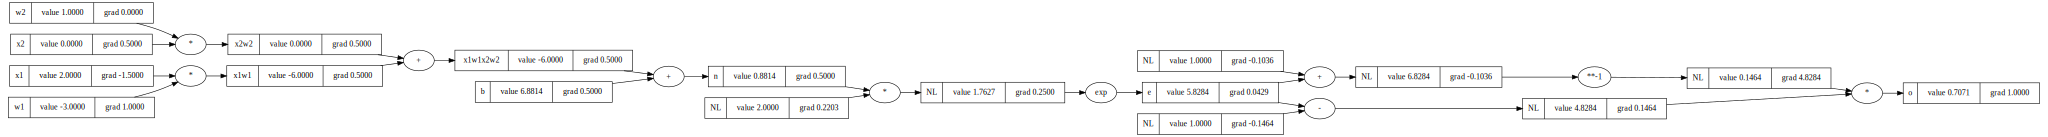

In [7]:
draw_dot(o)

In [8]:
x1 = torch.Tensor((2.0,)).type(torch.double)               ;x1.requires_grad = True
x2 = torch.Tensor((0.0,)).type(torch.double)               ;x2.requires_grad = True
b = torch.Tensor((6.8813735870195432,)).type(torch.double) ;b.requires_grad = True
w1 = torch.Tensor((-3.0,)).type(torch.double)              ;w1.requires_grad = True
w2 = torch.Tensor((1.0,)).type(torch.double)               ;w2.requires_grad = True

In [9]:
o = (x1 * w1 + x2 * w2 + b).tanh()

In [100]:
class Neuron:
    def __init__(self, nin):
        self.w = [Node(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Node(random.uniform(-1,1), _label='b')

    def __call__(self, x):
        act = sum((xi*wi for wi,xi in zip(self.w, x)), self.b) 
        return act.tanh()
    
class Layer:
    def __init__(self, nin, nout):
        self.layer = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        return [n(x) for n in self.layer]
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        out = self.layers[0](x)
        for l in self.layers[1:]:
            out = l(out)
        return out

In [101]:
n = Neuron(3)
l = Layer(2,2)
mlp = MLP(2,[1,3,1])

In [102]:
mlp([2,3])

[Node(value = 0.759156256227426)]

In [89]:
draw_dot(l([2,3]))

TypeError: unhashable type: 'list'

In [83]:
l(3)

TypeError: 'int' object is not iterable